## Import

In [1]:
from Utils.EDA import *
from Utils.Data_Preprocessing import *
from Utils.Models import *
from Utils.Evaluation import *
from Utils.plot_prediction import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In [2]:
df = load_data('Data/Tasla_Stock_Updated_V2.csv')

In [3]:
df_train, df_test = split_data(df)

In [4]:
df_train=create_features(df_train)
df_test=create_features(df_test)



In [5]:
df_full = create_features(df)


Original dataset shape: (1799, 14)
Augmented dataset shape: (2799, 14)


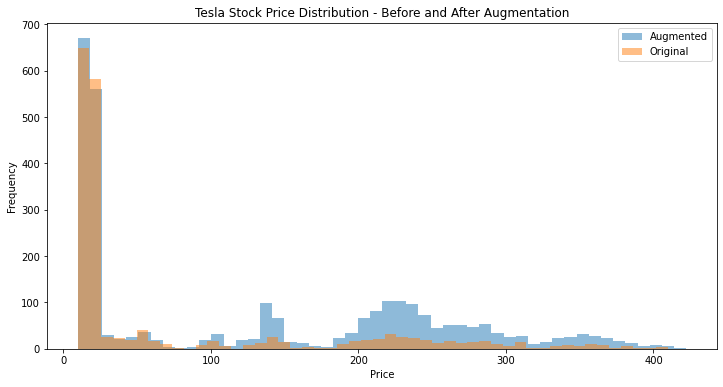

Original - Number of samples with price >= 100: 416
Augmented - Number of samples with price >= 100: 1416


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import timedelta

# Assuming df_full is your complete dataset with Tesla stock prices

# Define a threshold for high-price samples
threshold = 100  # Adjust based on your specific needs

# Function to augment data with time shifts
def augment_with_time_shift(df, num_samples=100, max_days_shift=10):
    """Create augmented samples by shifting dates slightly"""
    augmented_samples = []
    
    # Get high price samples
    high_price_df = df[df['Close'] >= threshold]
    
    # If there are no high price samples, return empty DataFrame
    if len(high_price_df) == 0:
        print("No high price samples found to augment")
        return pd.DataFrame(columns=df.columns)
    
    # Sample with replacement to create new samples
    for _ in range(num_samples):
        # Randomly select a high price sample
        sample = high_price_df.sample(1).iloc[0].copy()
        
        # Add a small random date shift (if date column exists)
        if 'Date' in df.columns:
            date_shift = random.randint(-max_days_shift, max_days_shift)
            if pd.api.types.is_datetime64_any_dtype(sample['Date']):
                # If date is already datetime
                sample['Date'] = sample['Date'] + timedelta(days=date_shift)
            elif isinstance(sample['Date'], str):
                # If date is stored as string, convert to datetime first
                sample['Date'] = pd.to_datetime(sample['Date']) + timedelta(days=date_shift)
        
        augmented_samples.append(sample)
    
    return pd.DataFrame(augmented_samples)

# Similarly for the price variation function
def augment_with_price_variation(df, num_samples=100, variation_pct=0.05):
    """Create augmented samples by adding noise to price values"""
    augmented_samples = []
    
    # Get high price samples
    high_price_df = df[df['Close'] >= threshold]
    
    # If there are no high price samples, return empty DataFrame
    if len(high_price_df) == 0:
        print("No high price samples found to augment")
        return pd.DataFrame(columns=df.columns)
    
    price_columns = ['Open', 'High', 'Low', 'Close']
    # Adjust the list above based on your actual column names
    
    # Sample with replacement to create new samples
    for _ in range(num_samples):
        # Randomly select a high price sample
        sample = high_price_df.sample(1).iloc[0].copy()
        
        # Add random noise to price columns
        for col in price_columns:
            if col in df.columns:
                # Add up to ±variation_pct% noise
                noise_factor = 1 + random.uniform(-variation_pct, variation_pct)
                sample[col] = sample[col] * noise_factor
        
        augmented_samples.append(sample)
    
    return pd.DataFrame(augmented_samples)

# Number of samples to augment (adjust as needed)
num_augmented_samples = 500  # Increase this if needed

# Generate augmented samples
augmented_df1 = augment_with_time_shift(df_train, num_samples=num_augmented_samples)
augmented_df2 = augment_with_price_variation(df_train, num_samples=num_augmented_samples)

# Combine augmented samples with original dataset
df_augmented = pd.concat([df_train, augmented_df1, augmented_df2], ignore_index=True)

# Sort by date if available
if 'Date' in df_augmented.columns:
    df_augmented = df_augmented.sort_values('Date')

print("Original dataset shape:", df_train.shape)
print("Augmented dataset shape:", df_augmented.shape)

# Visualize the price distribution after augmentation
plt.figure(figsize=(12, 6))
plt.hist(df_augmented['Close'], bins=50, alpha=0.5, label='Augmented')
plt.hist(df_train['Close'], bins=50, alpha=0.5, label='Original')
plt.title('Tesla Stock Price Distribution - Before and After Augmentation')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Verify that we've added more high-value samples
print(f"Original - Number of samples with price >= {threshold}: {len(df_train[df_train['Close'] >= threshold])}")
print(f"Augmented - Number of samples with price >= {threshold}: {len(df_augmented[df_augmented['Close'] >= threshold])}")

In [7]:
features_to_scale = ['Low','High','Open','Close','Volume' ,'Monthly_Return', 'MA5', 'MA10', 'MA20','Volatility_5','Volatility_10','Volatility_20','Target']
df_train_scaled, df_test_scaled, fitted_scaler = scale_features(df_train, df_test, features_to_scale)
print("example of scaled data")
print(df_test_scaled.head())

example of scaled data
            Unnamed: 0      Open      High       Low     Close    Volume  \
Date                                                                       
2022-04-21        1838  0.867589  0.875241  0.814450  0.815905  0.104926   
2022-04-22        1839  0.817985  0.827925  0.812414  0.812800  0.065389   
2022-04-25        1840  0.788183  0.806292  0.796684  0.806948  0.063889   
2022-04-26        1841  0.801832  0.799183  0.712313  0.705713  0.138925   
2022-04-27        1842  0.721522  0.731554  0.714298  0.709951  0.073425   

            Monthly_Return       MA5      MA10      MA20  Volatility_5  \
Date                                                                     
2022-04-21        0.593161  0.823160  0.872942  0.928009      0.217445   
2022-04-22        0.505230  0.826560  0.868272  0.927601      0.195730   
2022-04-25        0.497180  0.825497  0.865815  0.927019      0.198433   
2022-04-26        0.216777  0.799772  0.856914  0.917098      0.599414   


# EDA

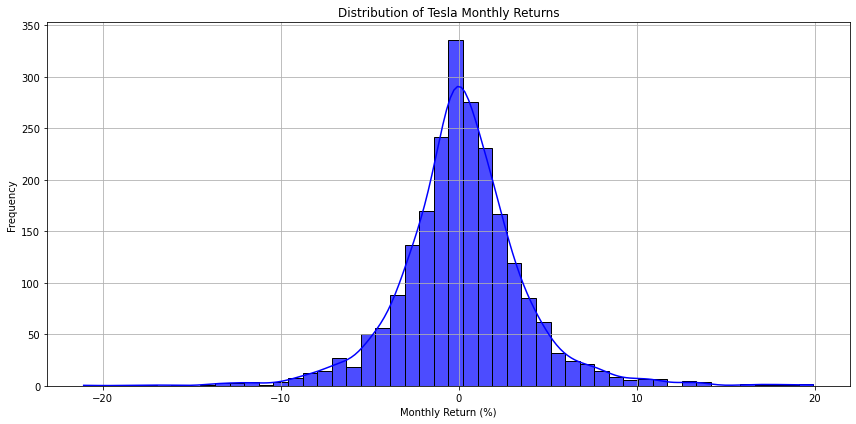

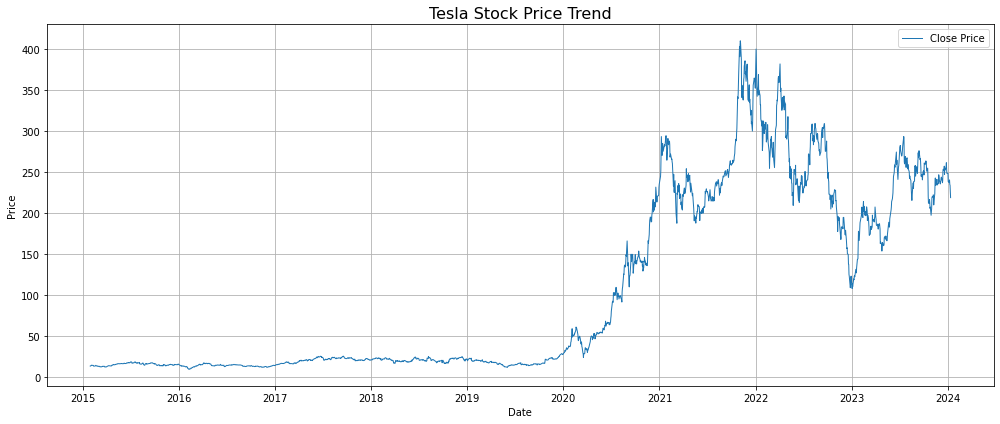

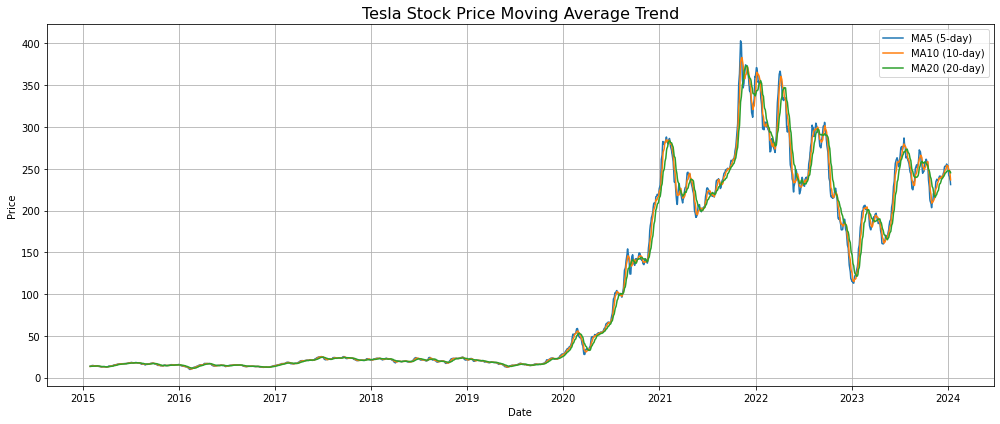

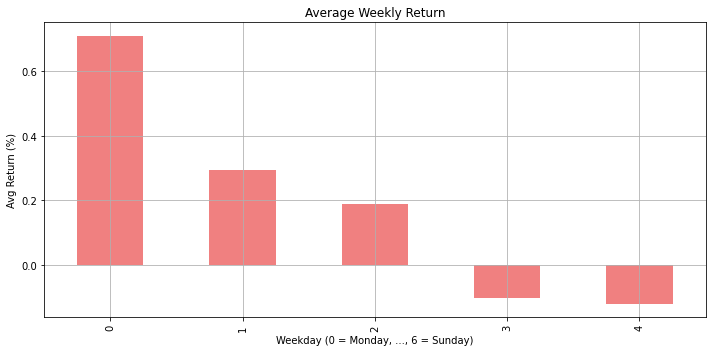

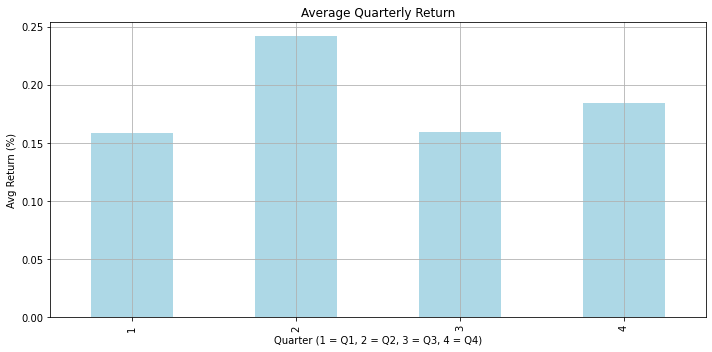

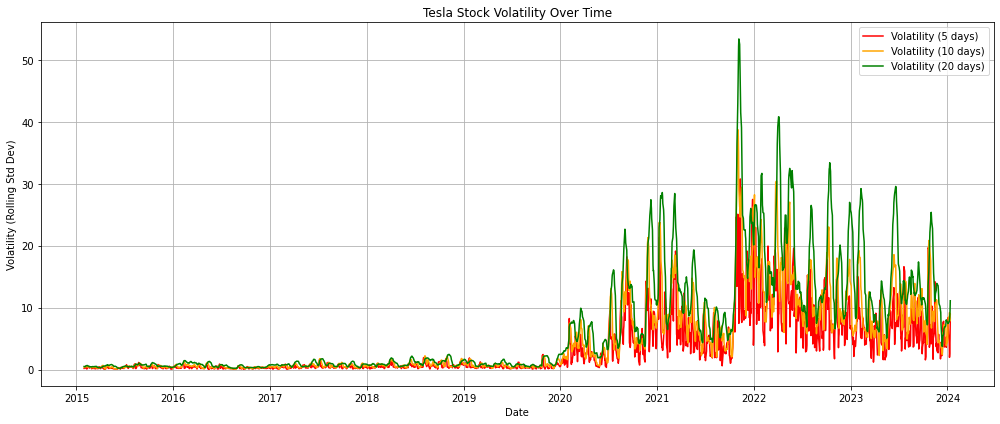

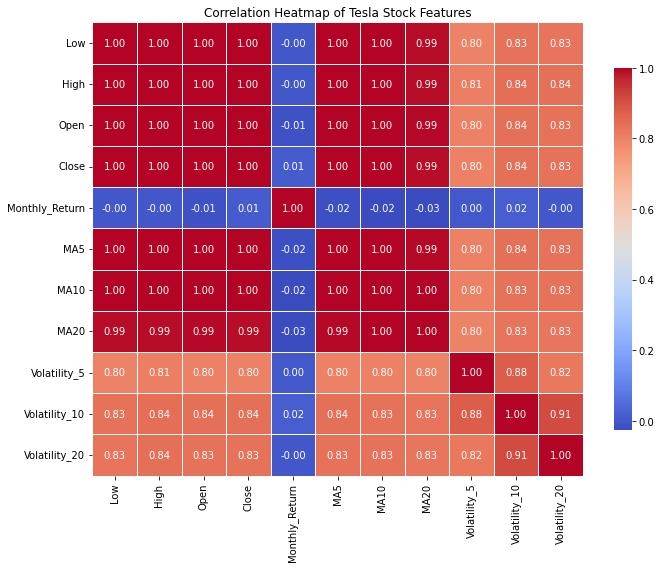

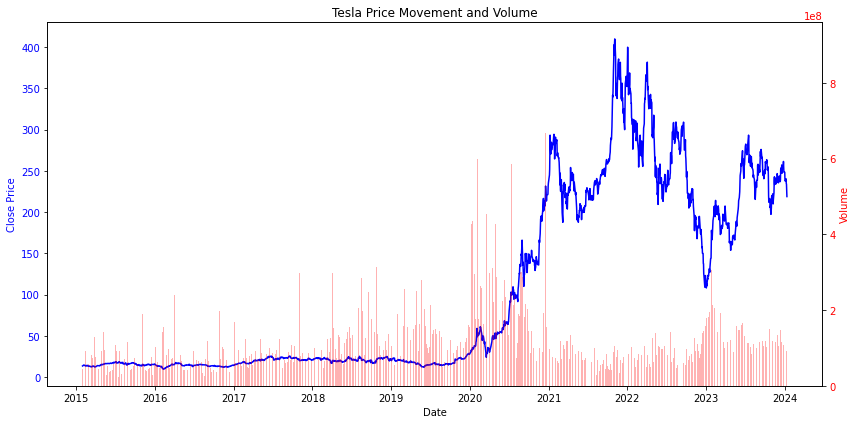

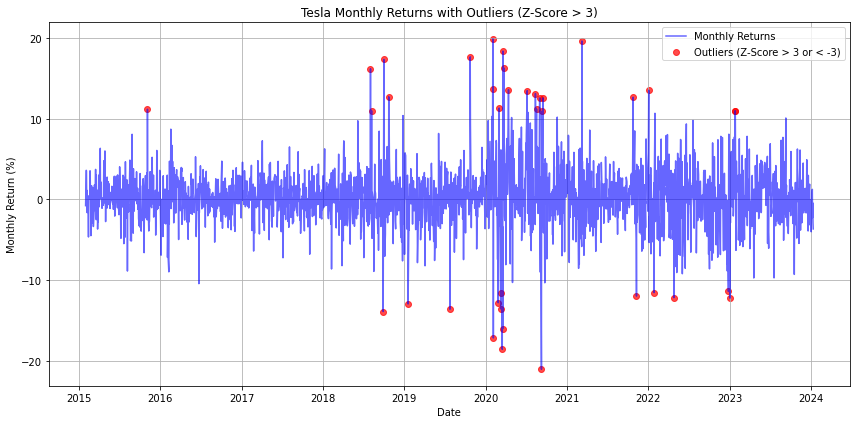

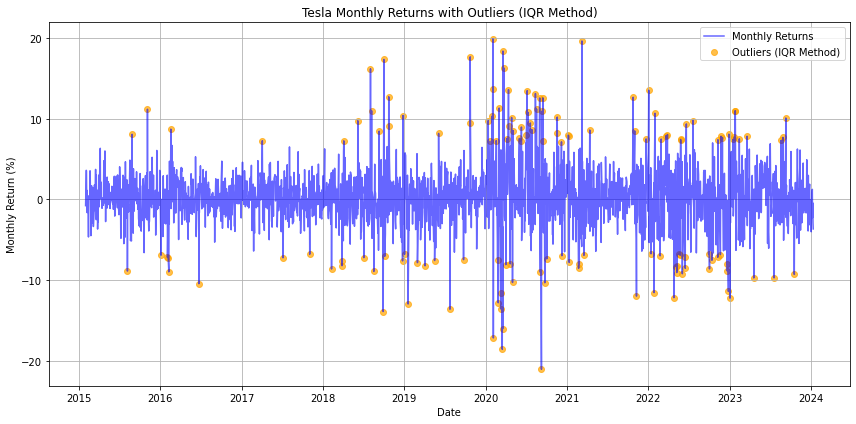

Sharpe Ratio: 0.0519


/Users/rakibabdullah/Desktop/Tesla-S/Utils/EDA.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative_Return'] = (1 + df['Daily_Return'] / 100).cumprod() - 1
/Users/rakibabdullah/Desktop/Tesla-S/Utils/EDA.py:155: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').last()


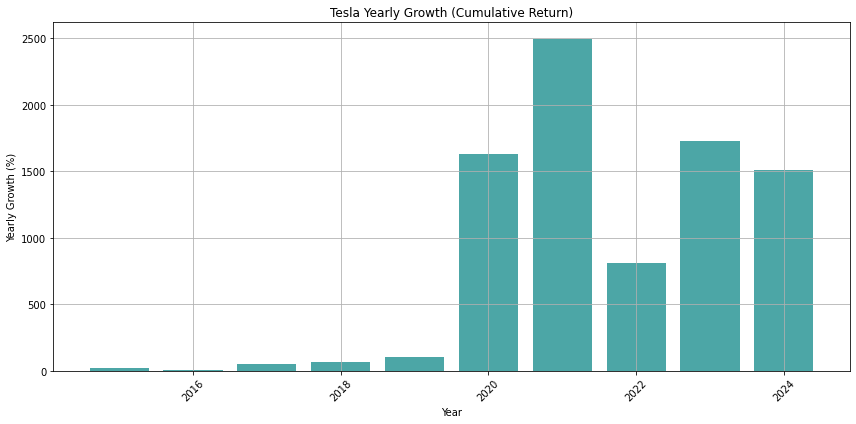

In [8]:
plot_monthly_return_distribution(df_full) # distribution of monthly returns
plot_stock_price_trend(df_full) 
plot_moving_averages(df_full) 

plot_weekly_avg_return(df_full) # weekly average return seasonality
plot_quarterly_seasonality(df_full) # quarterly seasonality

plot_volatility(df_full) #volatility over time
plot_correlation_heatmap(df_full) #correlation heatmap between features
plot_volume_vs_price(df_full) # volume vs price movement

plot_zscore_outliers(df_full) # z-score outliers
plot_iqr_outliers(df_full) 

calculate_sharpe_ratio(df_full)
plot_cumulative_returns(df_full)



In [9]:
import sys
print(sys.executable)
print(sys.version)


/usr/local/bin/python3
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


# Model Tranining and Testing

In [10]:
results_normal_training = []

## SMA

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0123
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0157
R-squared (R²): 0.9807
Mean Absolute Percentage Error (MAPE): 2.3518%




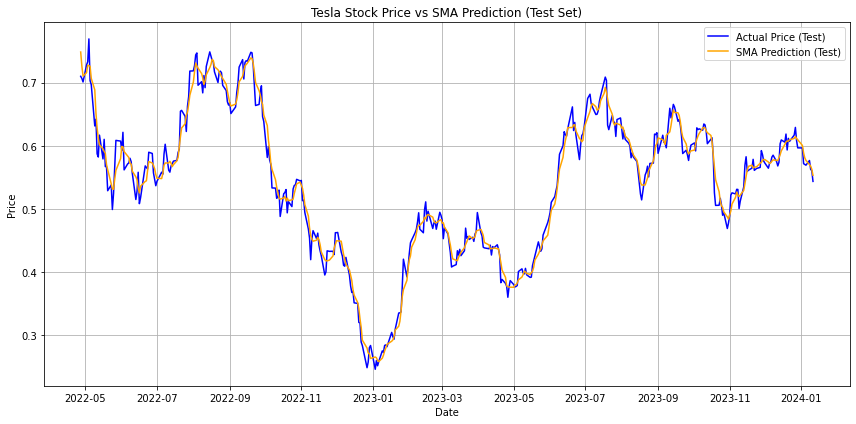

In [11]:
# Apply Simple Moving Average (SMA) to the test set
df_test_scaled['SMA_Prediction'] = simple_moving_average_model(df_test_scaled, window=5)

df_test_scaled.dropna(inplace=True)

mae, mse, rmse, r2, mape=evaluate_model(df_test_scaled['Close'], df_test_scaled['SMA_Prediction'])
results_normal_training.append({
    'Model': 'Simple Moving Average',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

plot_simple_moving_average(df_test_scaled)

## Linear Regression

In [12]:
y_test, y_pred = linear_regression_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred) 

results_normal_training.append({
    'Model': 'Linear Regression',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
}) 

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0153
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0204
R-squared (R²): 0.9674
Mean Absolute Percentage Error (MAPE): 26.3415%




In [13]:
volatility_period_metrics = []

In [14]:
import plotly.graph_objects as go

def plot_test_train_prediction_plotly(model_name, df_train, df_test, y_pred):
    """
    Interactive version of train, test, and predicted stock price plot using Plotly.
    
    Parameters:
    - model_name: str, name of the model for the legend/title
    - df_train: DataFrame containing the training data (must have 'Close' column)
    - df_test: DataFrame containing the test data (must have 'Close' column)
    - y_pred: Predicted values (must match length of df_test)
    """
    
    fig = go.Figure()

    # Train data
    fig.add_trace(go.Scatter(
        x=df_train.index,
        y=df_train['Close'],
        mode='lines',
        name='Train',
        line=dict(color='teal')
    ))

    # Test data
    fig.add_trace(go.Scatter(
        x=df_test.index,
        y=df_test['Close'],
        mode='lines',
        name='Test',
        line=dict(color='magenta')
    ))

    # Predictions
    fig.add_trace(go.Scatter(
        x=df_test.index,
        y=y_pred,
        mode='lines',
        name=f'{model_name} Predictions',
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=f'{model_name} Predictions vs Actual Test Data',
        xaxis_title='Date',
        yaxis_title='Close Price USD ($)',
        legend=dict(x=0, y=1.1, orientation="h"),
        template='plotly_white',
        height=600,
        width=1000,
        margin=dict(l=50, r=50, t=80, b=50),
        hovermode='x unified'
    )

    fig.show()


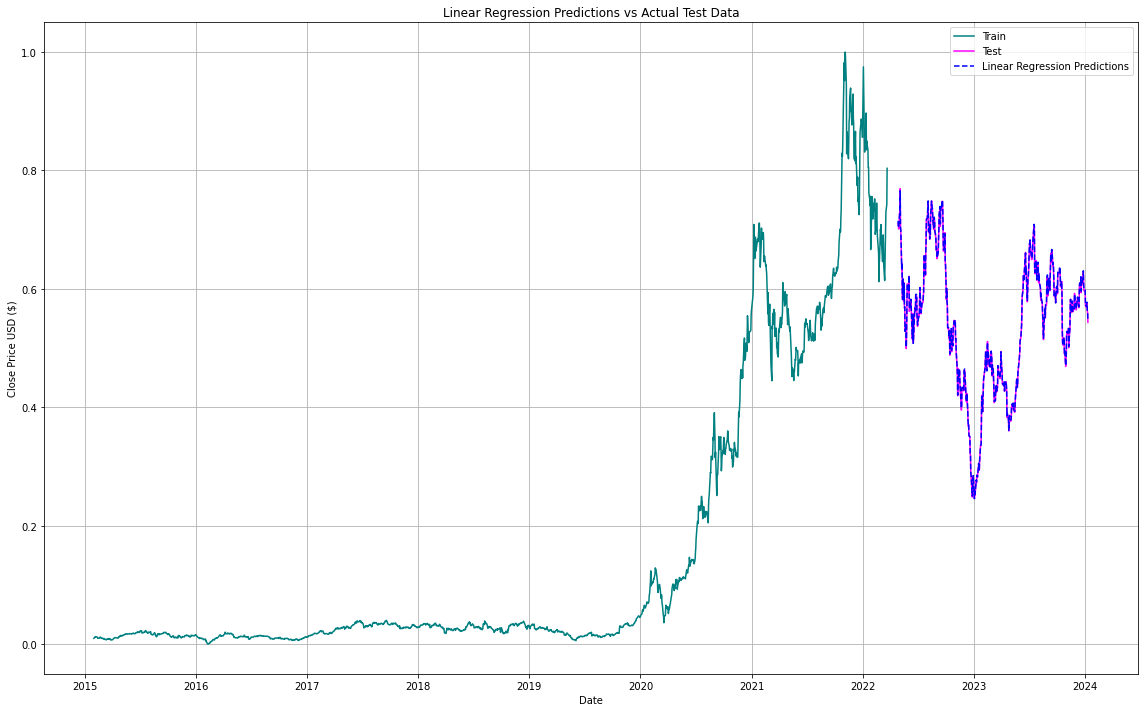

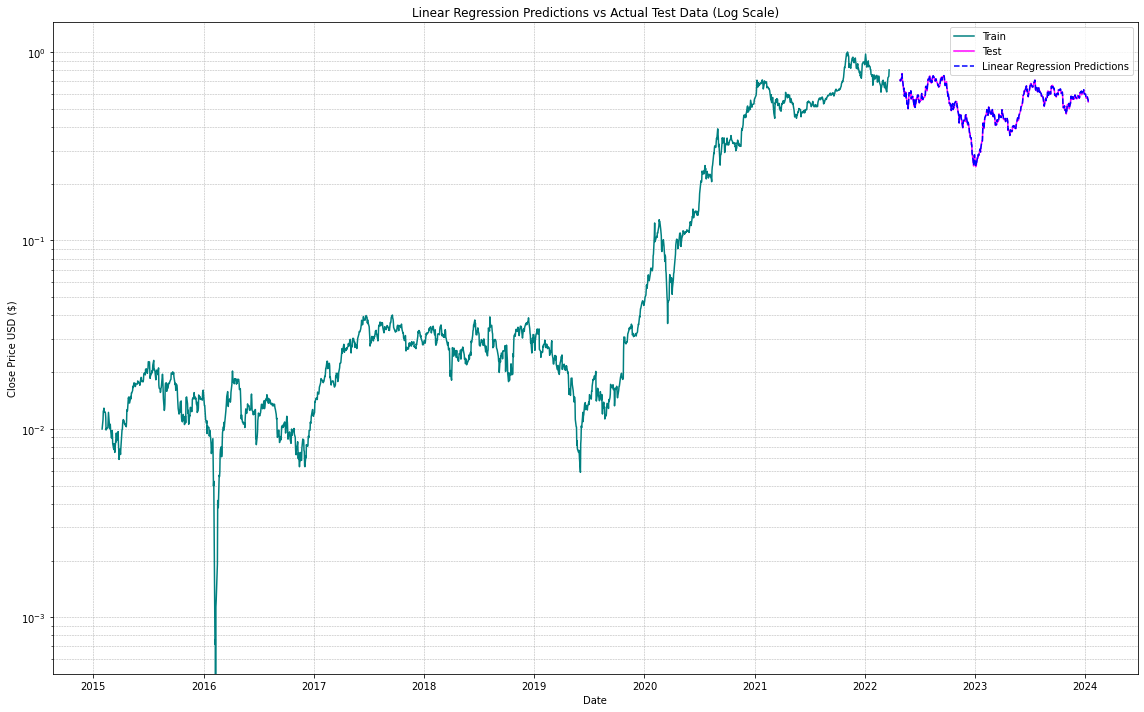

In [15]:
plot_test_train_prediction("Linear Regression",df_train_scaled, df_test_scaled, y_pred)
plot_test_train_prediction_log("Linear Regression",df_train_scaled, df_test_scaled, y_pred)


Mean Absolute Error (MAE) during High Volatility: 0.015309882261995223
Root Mean Squared Error (RMSE) during High Volatility: 0.020555247381435854


/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


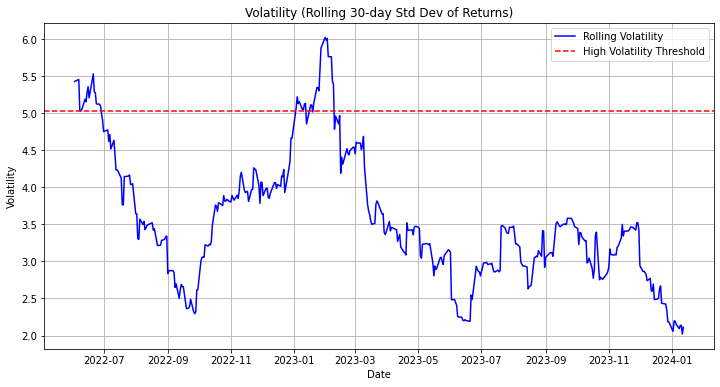

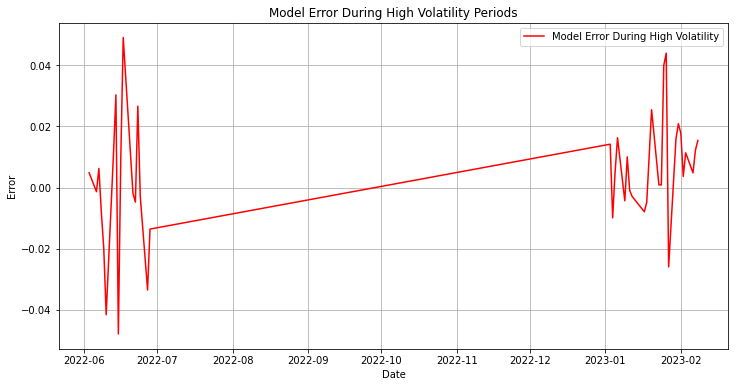

In [16]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("Linear Regression", mae_volatility, rmse_volatility))

## XGBoost

In [17]:
y_test, y_pred= xgboost_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred)

results_normal_training.append({
    'Model': 'XGBoost',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0217
Mean Squared Error (MSE): 0.0008
Root Mean Squared Error (RMSE): 0.0278
R-squared (R²): 0.9397
Mean Absolute Percentage Error (MAPE): 4.2362%




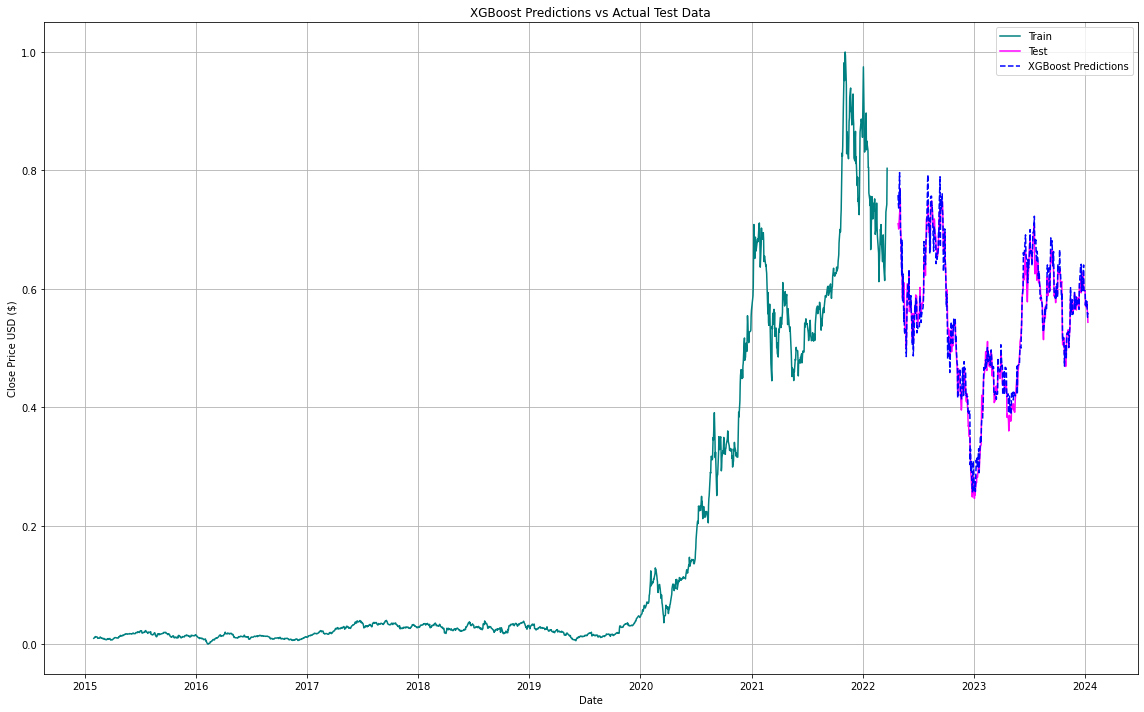

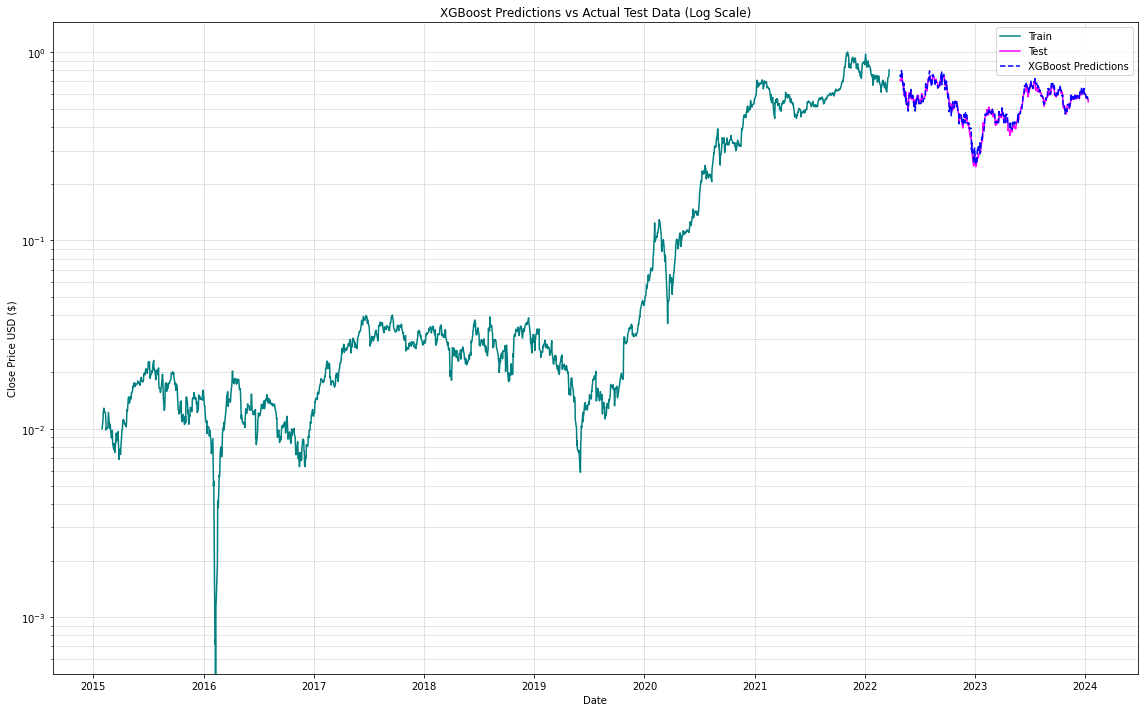

In [18]:
plot_test_train_prediction("XGBoost",df_train_scaled, df_test_scaled, y_pred)
plot_test_train_prediction_log("XGBoost",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.020909474141556895
Root Mean Squared Error (RMSE) during High Volatility: 0.025450468786200896


/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


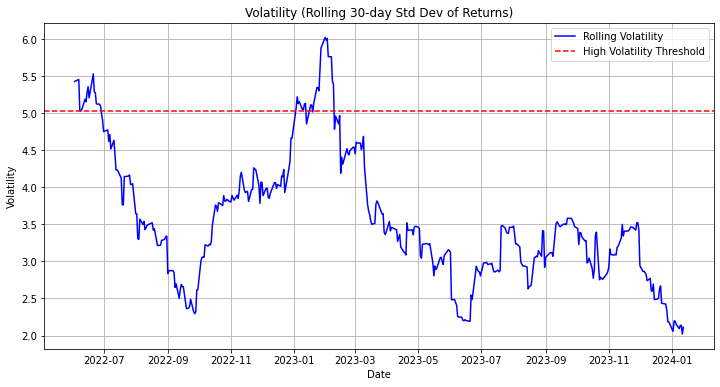

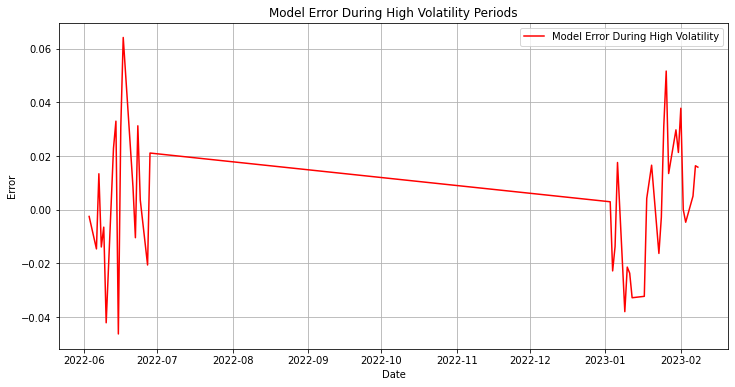

In [19]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("XgBoost", mae_volatility, rmse_volatility))

## RandomForestRegressor

In [20]:
y_test, y_pred = random_forest_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred) 

results_normal_training.append({
    'Model': 'Random Forest',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0209
Mean Squared Error (MSE): 0.0007
Root Mean Squared Error (RMSE): 0.0270
R-squared (R²): 0.9432
Mean Absolute Percentage Error (MAPE): 4.2403%




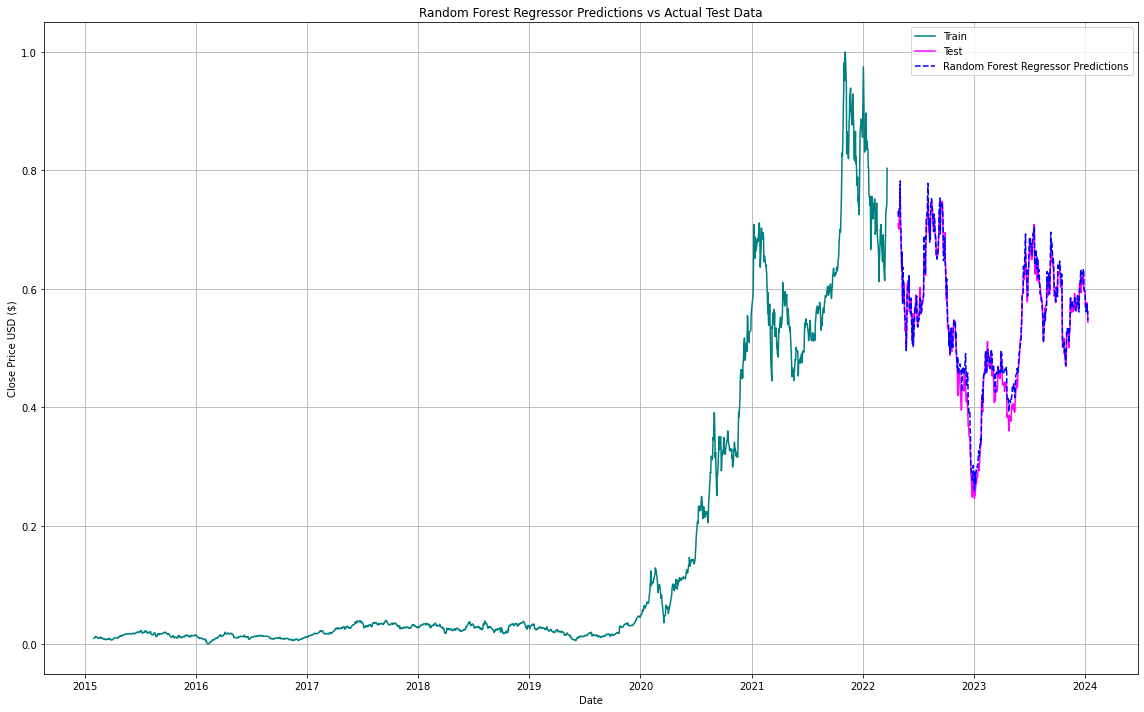

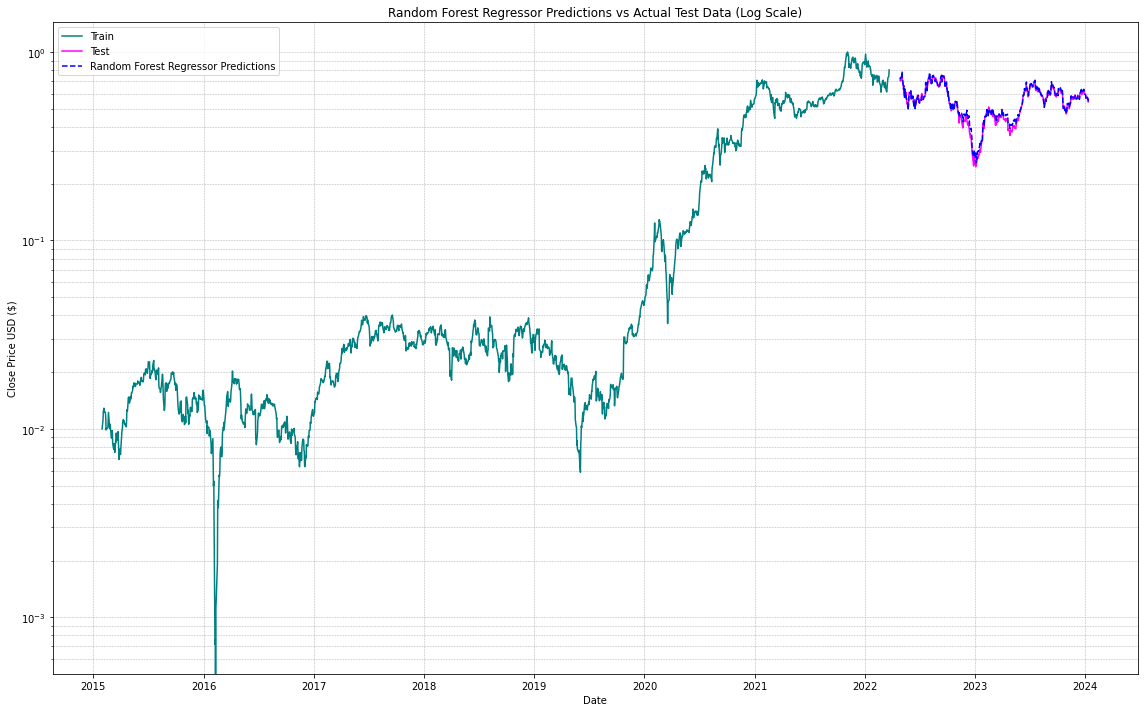

In [21]:
plot_test_train_prediction("Random Forest Regressor",df_train_scaled, df_test_scaled, y_pred)
plot_test_train_prediction_log("Random Forest Regressor",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.018924793196041016
Root Mean Squared Error (RMSE) during High Volatility: 0.022731202103230475


/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


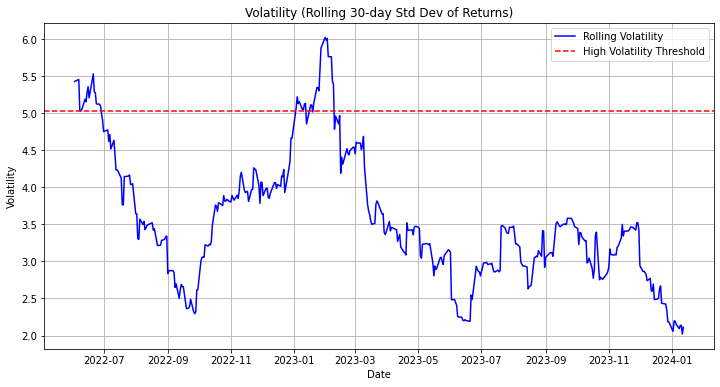

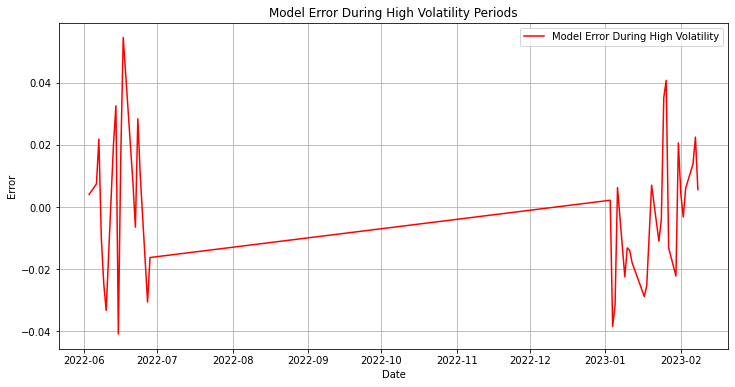

In [22]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("Random forest regressor", mae_volatility, rmse_volatility))

## SVR

In [23]:
y_test, y_pred = svr_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred) 

results_normal_training.append({
    'Model': 'Support Vector Regressor',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0208
Mean Squared Error (MSE): 0.0007
Root Mean Squared Error (RMSE): 0.0261
R-squared (R²): 0.9466
Mean Absolute Percentage Error (MAPE): 4.1836%




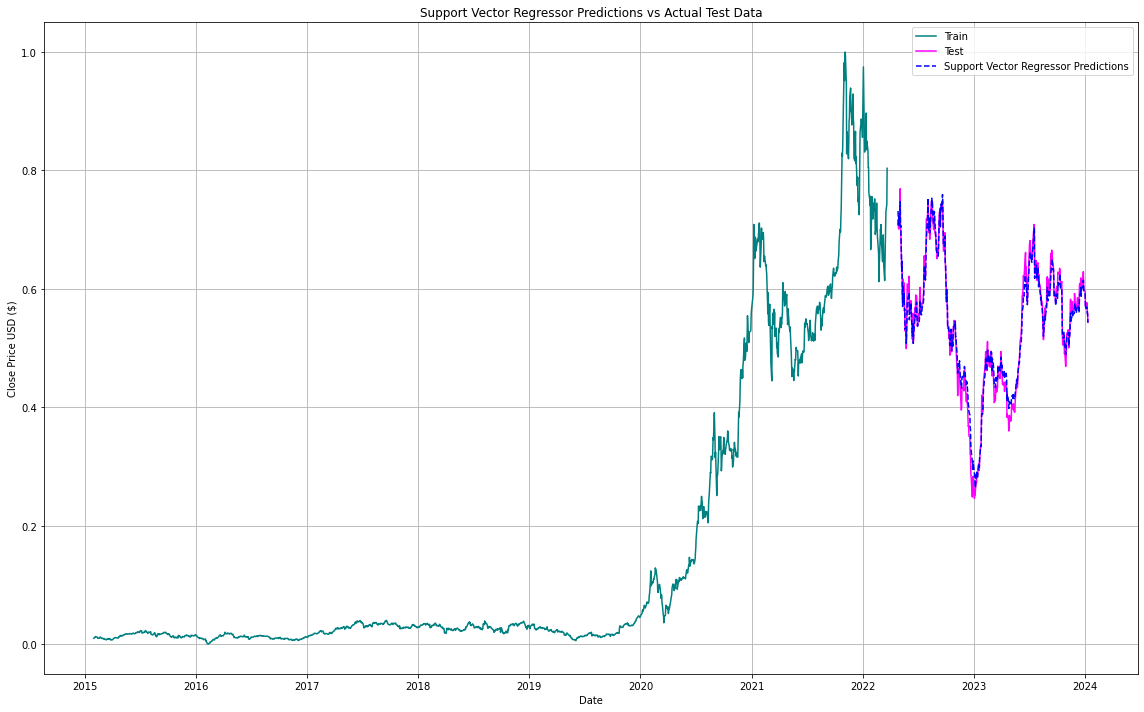

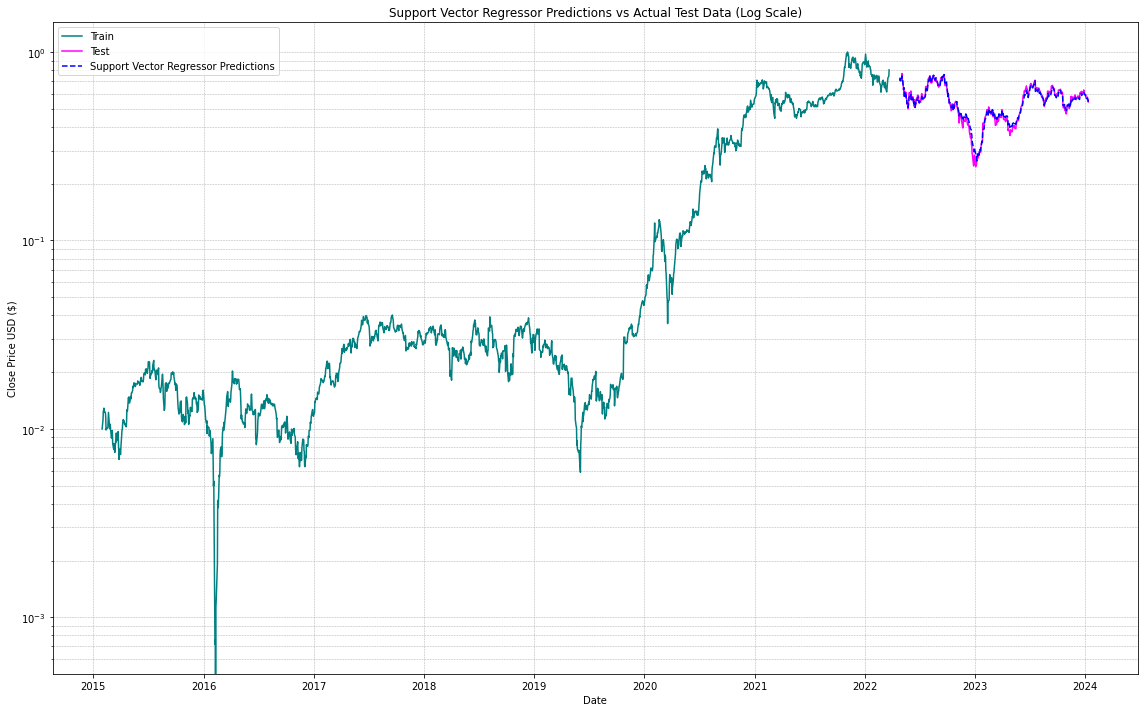

In [24]:
plot_test_train_prediction("Support Vector Regressor",df_train_scaled, df_test_scaled, y_pred)
plot_test_train_prediction_log("Support Vector Regressor",df_train_scaled, df_test_scaled, y_pred)

/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


Mean Absolute Error (MAE) during High Volatility: 0.019042302445367837
Root Mean Squared Error (RMSE) during High Volatility: 0.022928910003380952


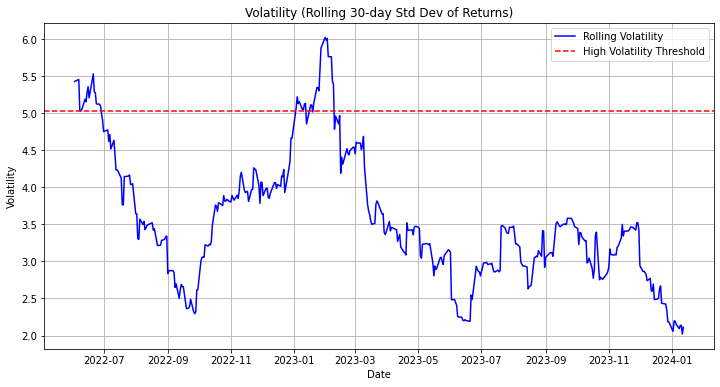

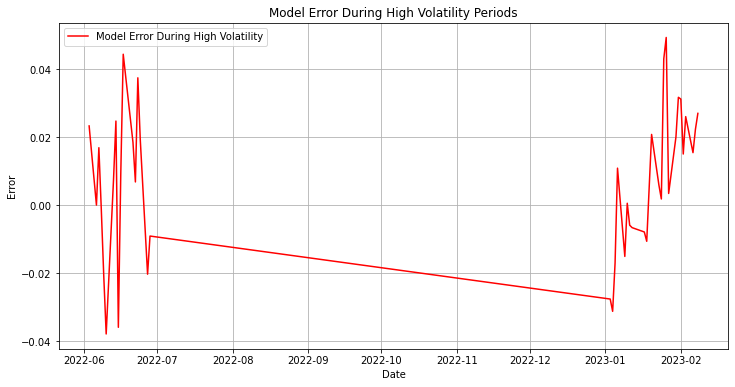

In [25]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("SVR", mae_volatility, rmse_volatility))

## DT regressor

In [26]:
y_test, y_pred = decision_tree_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred) 

results_normal_training.append({
    'Model': 'Decision Tree',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0299
Mean Squared Error (MSE): 0.0014
Root Mean Squared Error (RMSE): 0.0377
R-squared (R²): 0.8889
Mean Absolute Percentage Error (MAPE): 5.6928%




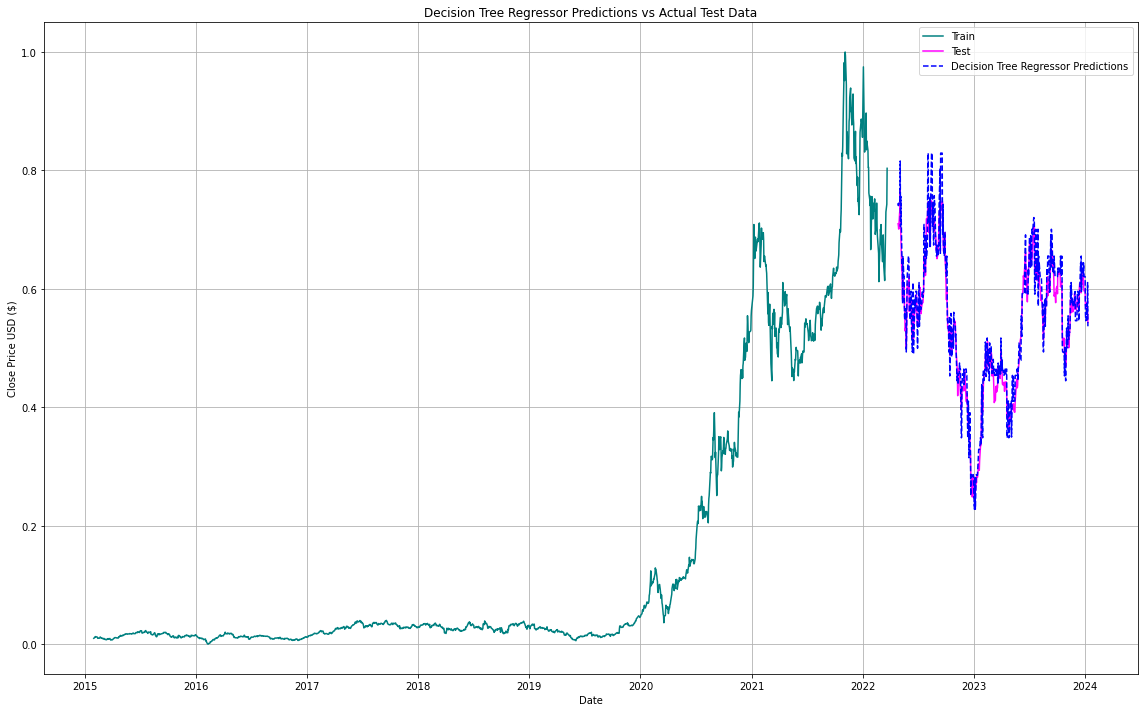

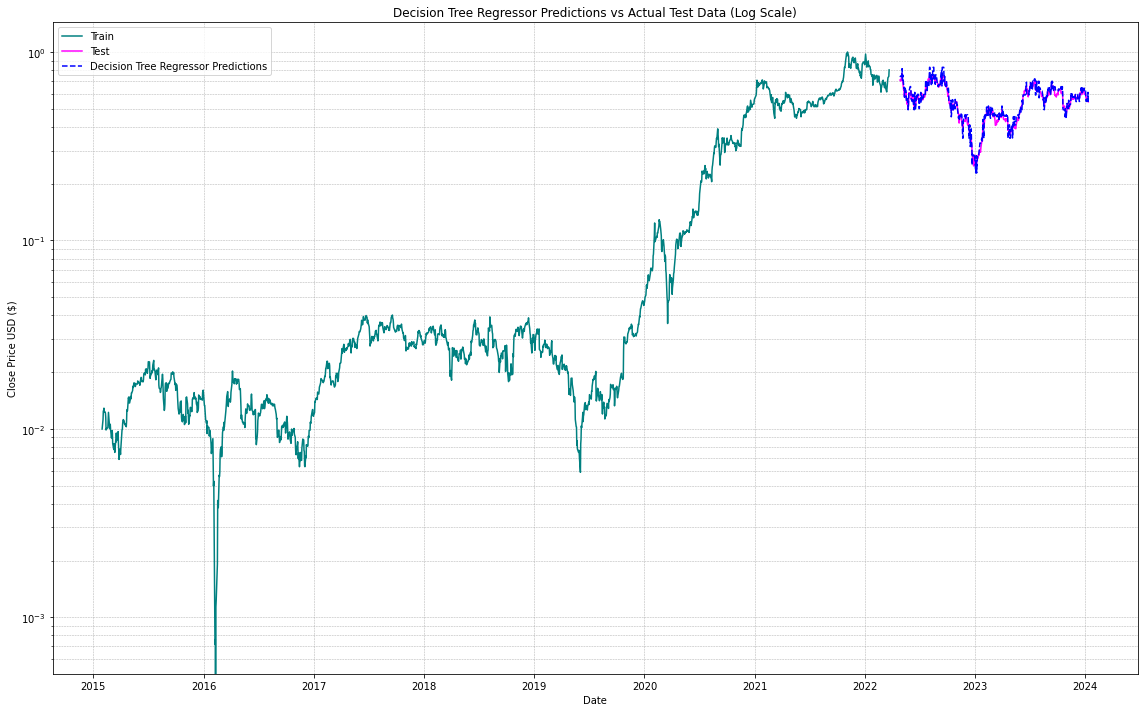

In [27]:
plot_test_train_prediction("Decision Tree Regressor",df_train_scaled, df_test_scaled, y_pred)
plot_test_train_prediction_log("Decision Tree Regressor",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.025382194512731115
Root Mean Squared Error (RMSE) during High Volatility: 0.032807470230865145


/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


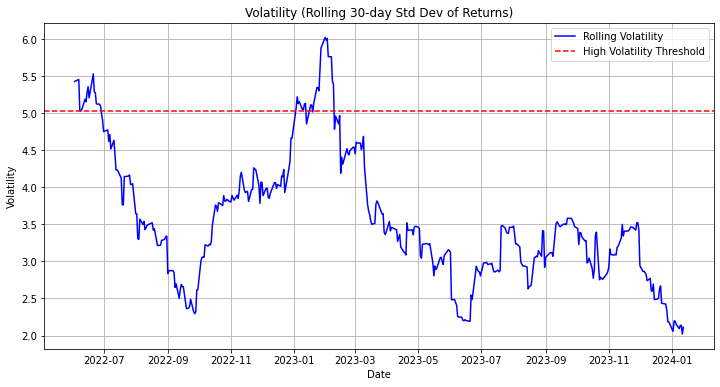

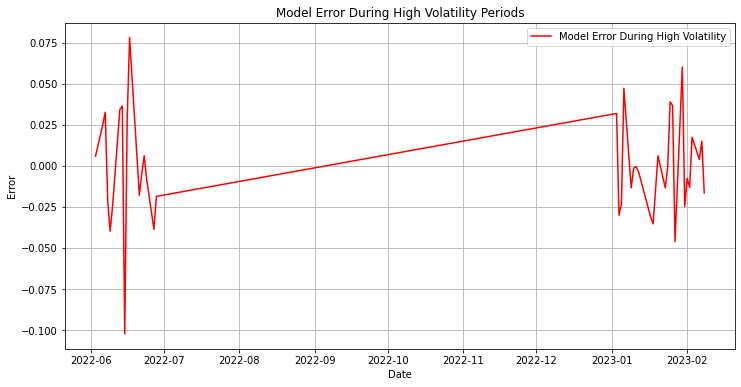

In [28]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("DT regressor", mae_volatility, rmse_volatility))

## Voting Ensemble Model

In [29]:
y_test, y_pred = voting_model(df_train_scaled, df_test_scaled)
mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred)

results_normal_training.append({
    'Model': 'Voting Ensemble',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0176
Mean Squared Error (MSE): 0.0005
Root Mean Squared Error (RMSE): 0.0229
R-squared (R²): 0.9591
Mean Absolute Percentage Error (MAPE): 3.5011%




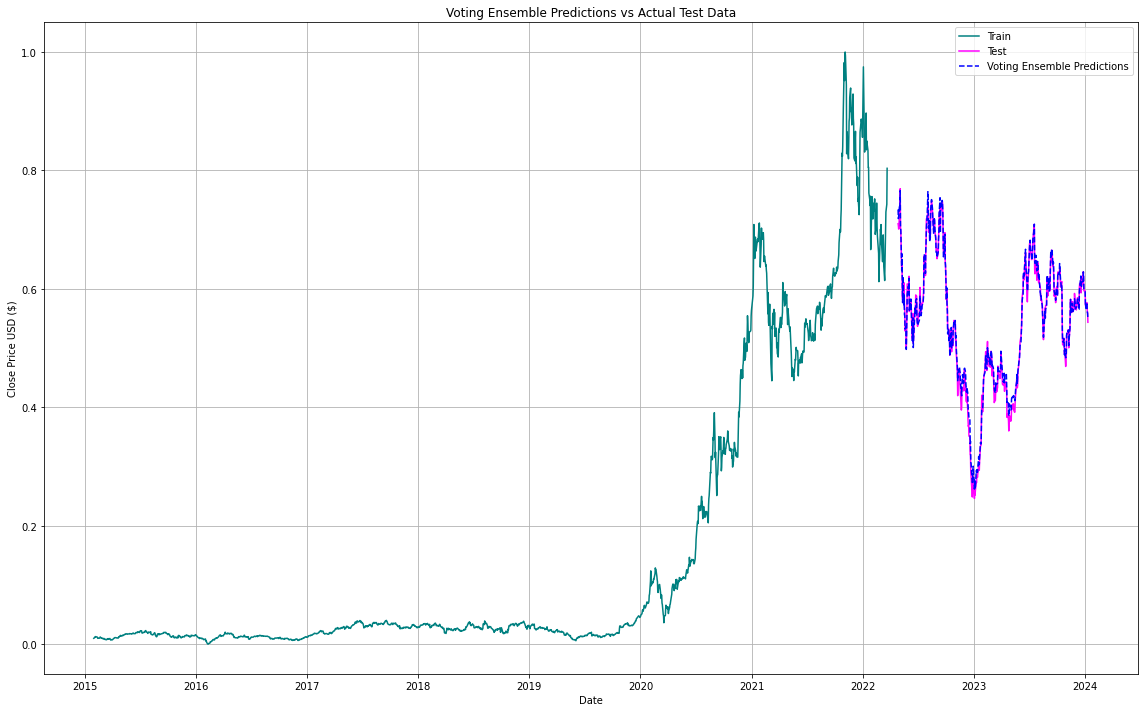

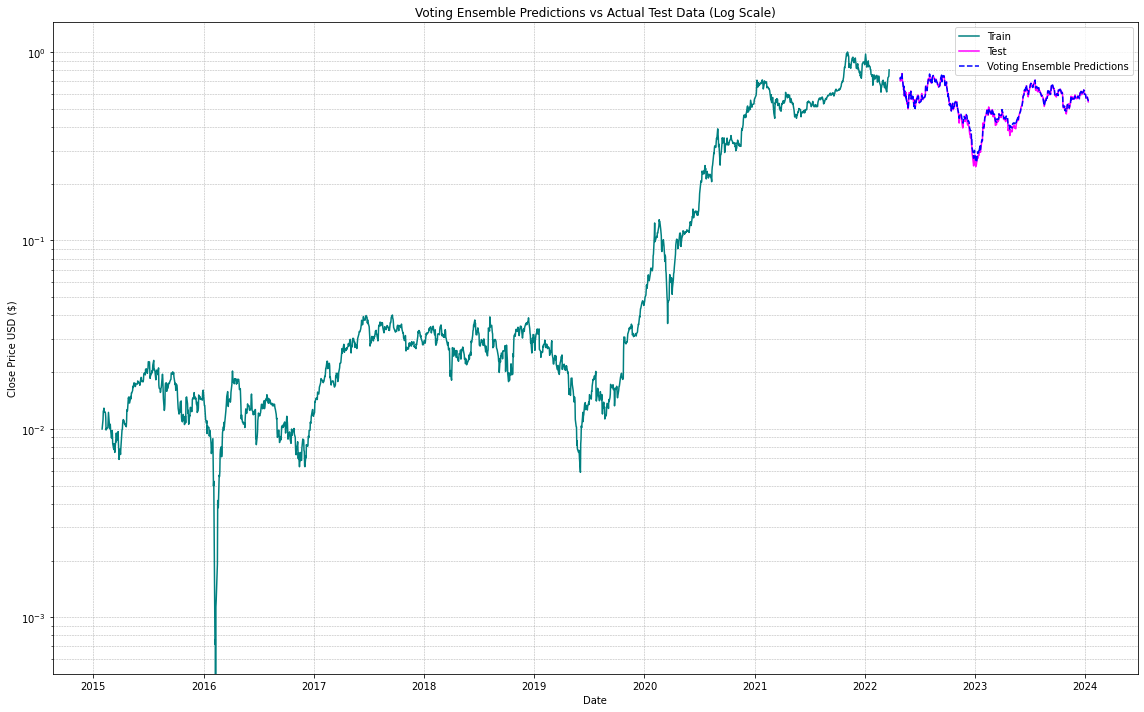

In [30]:
plot_test_train_prediction("Voting Ensemble",df_train_scaled, df_test_scaled, y_pred)
plot_test_train_prediction_log("Voting Ensemble",df_train_scaled, df_test_scaled, y_pred)

In [31]:
# from pylab import rcParams
# import statsmodels.api as sm
# rcParams['figure.figsize'] = 20, 10
# decomposition = sm.tsa.seasonal_decompose(df_full.Close, model='multiplicative',period=252) # additive seasonal index
# fig = decomposition.plot()
# plt.show()

# train_len = int(len(df_full) * 0.83) # 80% of the data for training
# train = df_full[0:train_len] 
# test = df_full[train_len:] 

# from statsmodels.tsa.stattools import adfuller
# adf_test = adfuller(df_full['Close'])

# print('ADF Statistic: %f' % adf_test[0])
# print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
# print('p-value: %f' % adf_test[1])


# from scipy.stats import boxcox
# data_boxcox = pd.Series(boxcox(df_full['Close'], lmbda=0), index = df_full.index)

# df_full['Close'].plot(figsize=(20, 5))
# plt.grid()
# plt.plot(data_boxcox, label='After Box Cox tranformation')
# plt.legend(loc='best')
# plt.title('After Box Cox transform')
# plt.show()

# data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df_full.index)
# plt.figure(figsize=(20,5))
# plt.grid()
# plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
# plt.legend(loc='best')
# plt.title('After Box Cox transform and differencing')
# plt.show()

# data_boxcox_diff.dropna(inplace=True)

# adf_test = adfuller(data_boxcox_diff)

# print('ADF Statistic: %f' % adf_test[0])
# print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
# print('p-value: %f' % adf_test[1])

# train_data_boxcox = data_boxcox[:train_len]
# test_data_boxcox = data_boxcox[train_len:]
# train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
# test_data_boxcox_diff = data_boxcox_diff[train_len-1:]


## Prophet

16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing


MAE: 186.97233007672503
RMSE: 208.90648213651082
R² Score: -11.829534264145655


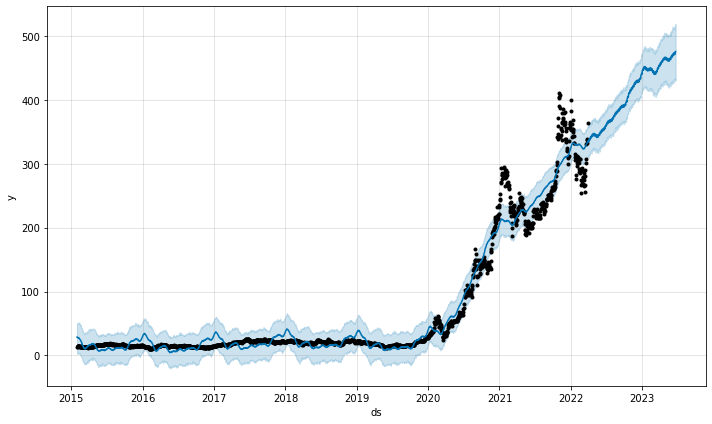

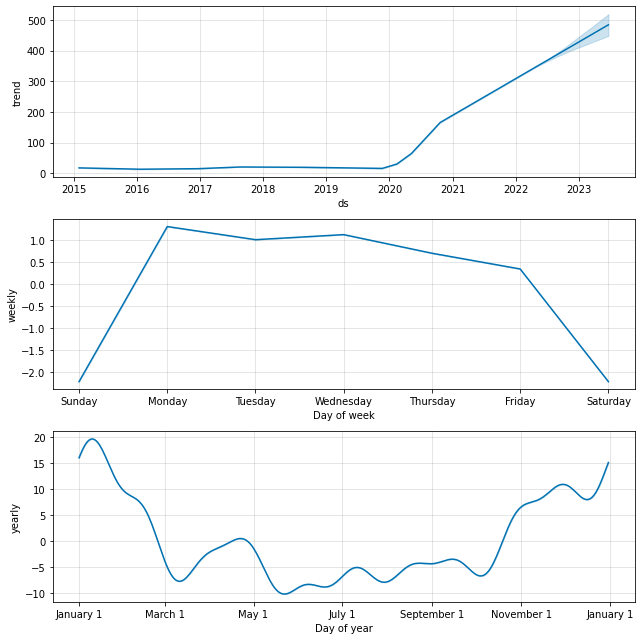

In [32]:
run_and_evaluate_prophet(df_full)

## LSTM

In [33]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU


In [35]:
from Utils.Models import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Reloading Tuner from hyperparameter_tuning/lstm_hyperparameter_tuning/tuner0.json
Best hyperparameters: {'lstm_units_1': 150, 'dropout_1': 0.2, 'lstm_units_2': 200, 'dropout_2': 0.1, 'dense_units': 64, 'learning_rate': 0.00033612834408703365}
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1309
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2829e-04 - root_mean_squared_error: 0.0151 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4456e-04 - root_mean_squared_error: 0.0120 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0036e-04 - root_mean_squared_error: 0.0100 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1652e-04 - root_mean_squared_error: 0.0108 - val_loss: 0

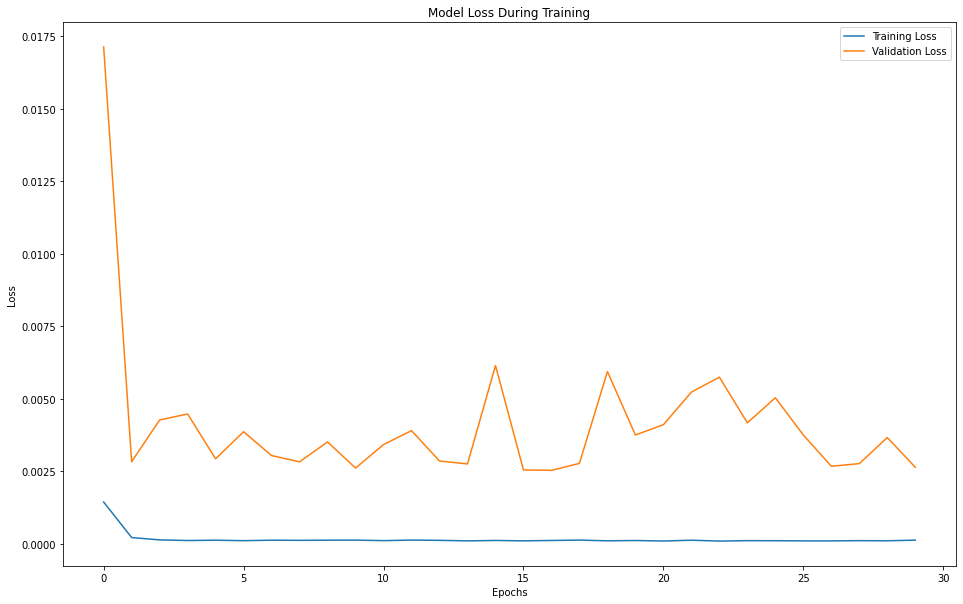

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0408
Mean Squared Error (MSE): 0.0025
Root Mean Squared Error (RMSE): 0.0504
R-squared (R²): 0.7974
Mean Absolute Percentage Error (MAPE): 26.0433%




In [36]:
y_test, y_pred = lstm_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred) 

results_normal_training.append({
    'Model': 'LSTM',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

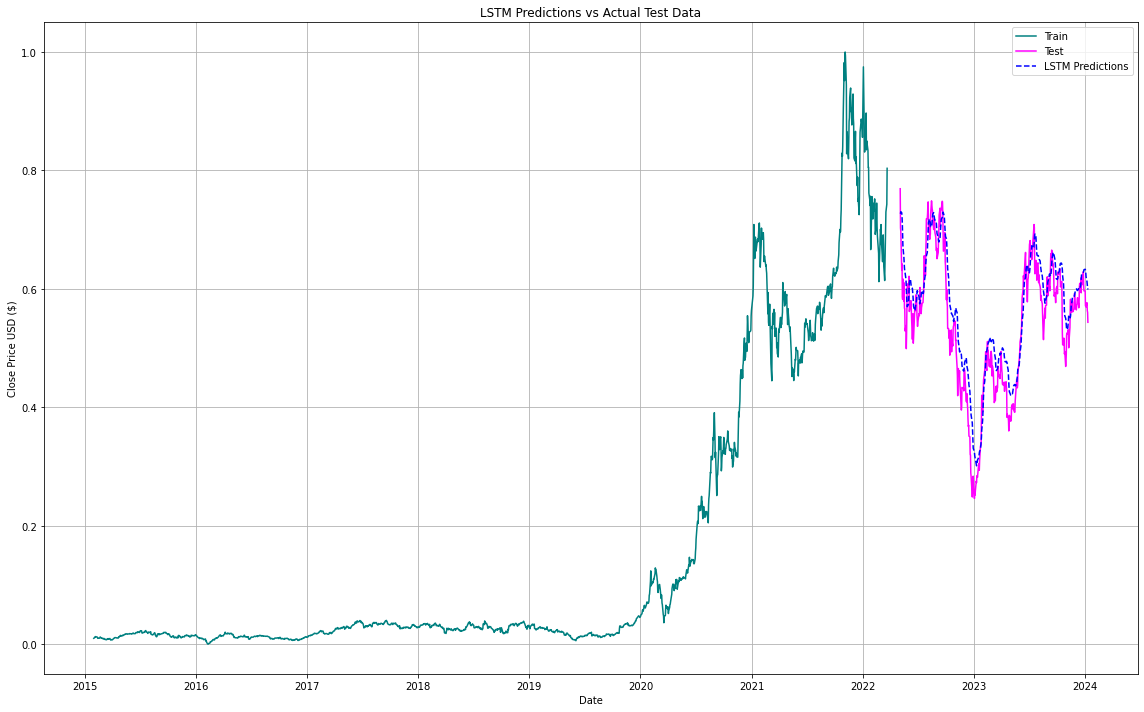

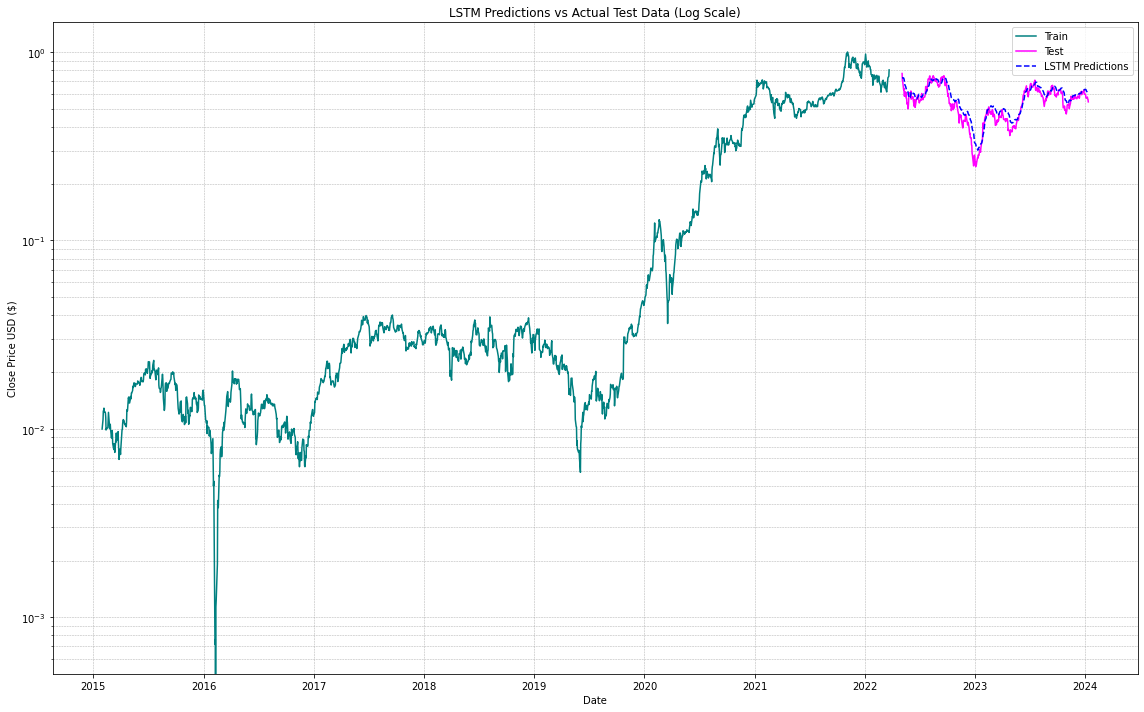

In [37]:
plot_test_train_prediction("LSTM",df_train_scaled, df_test_scaled[5:], y_pred)
plot_test_train_prediction_log("LSTM",df_train_scaled, df_test_scaled[5:], y_pred)



Mean Absolute Error (MAE) during High Volatility: 0.03274677605645514
Root Mean Squared Error (RMSE) during High Volatility: 0.03984143984864997


/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:88: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:94: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

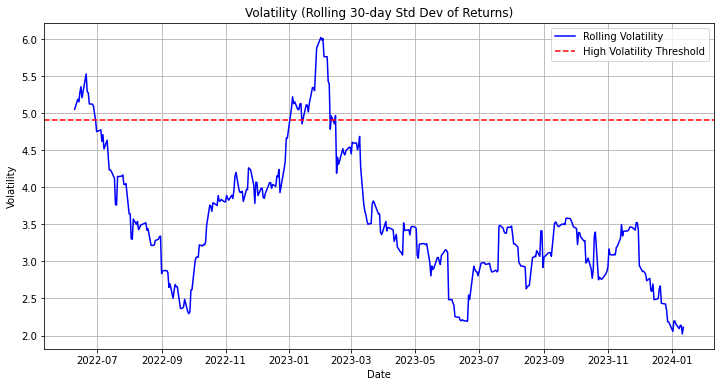

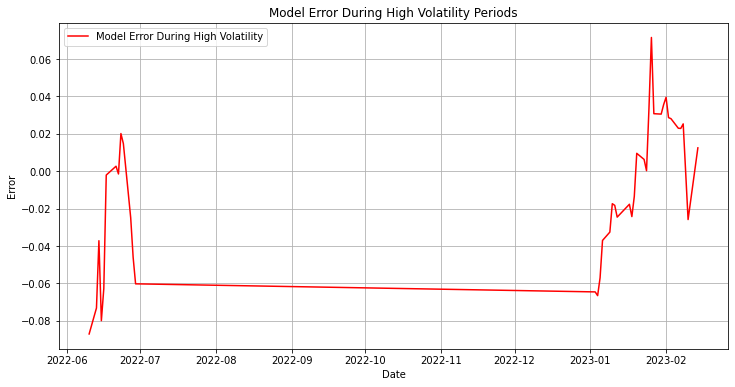

In [38]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test[5:], df_test_scaled[5:], y_pred)

volatility_period_metrics.append(("LSTM", mae_volatility, rmse_volatility))

## GRU Model

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Reloading Tuner from hyperparameter_tuning_gru/gru_hyperparameter_tuning/tuner0.json
Best hyperparameters: {'gru_units_1': 150, 'dropout_1': 0.1, 'gru_units_2': 200, 'dropout_2': 0.1, 'gru_units_3': 150, 'dense_units': 96, 'dropout_3': 0.5, 'learning_rate': 8.327414044844959e-05}
Epoch 1/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0018 - root_mean_squared_error: 0.0409 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 2/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.3033e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
Epoch 3/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.6332e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 4/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8517e-04 - root_mean_squared_error: 0.0169 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 5/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.6838e-04

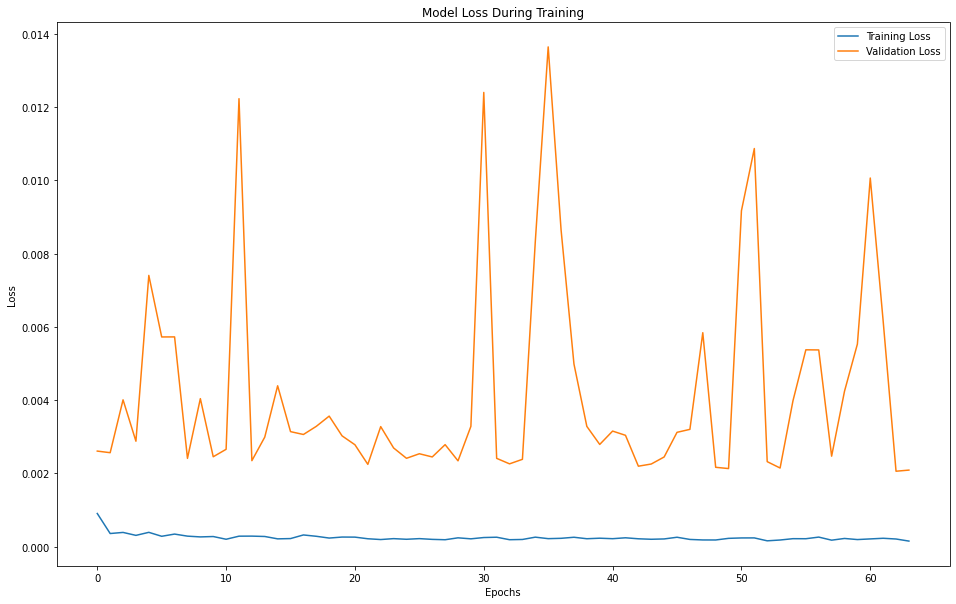

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0329
Mean Squared Error (MSE): 0.0017
Root Mean Squared Error (RMSE): 0.0411
R-squared (R²): 0.8653
Mean Absolute Percentage Error (MAPE): 25.9167%




In [39]:
y_test, y_pred = gru_model(df_train_scaled, df_test_scaled)

mae, mse, rmse, r2, mape=evaluate_model(y_test, y_pred)

results_normal_training.append({
    'Model': 'GRU',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape
})

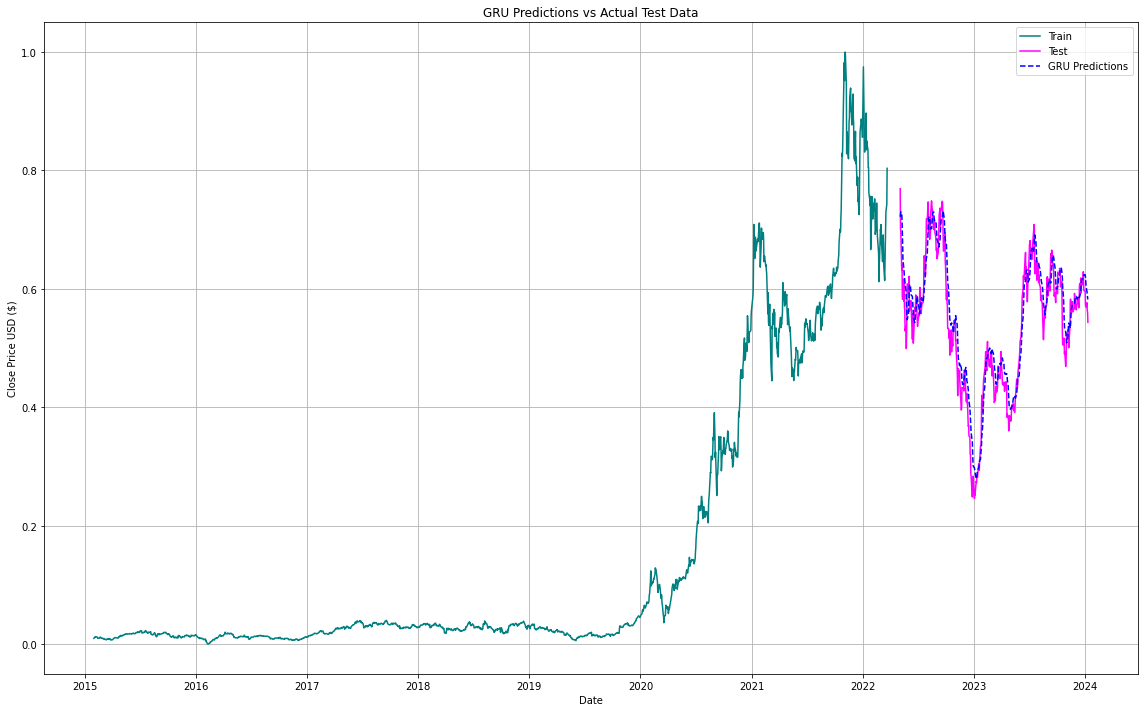

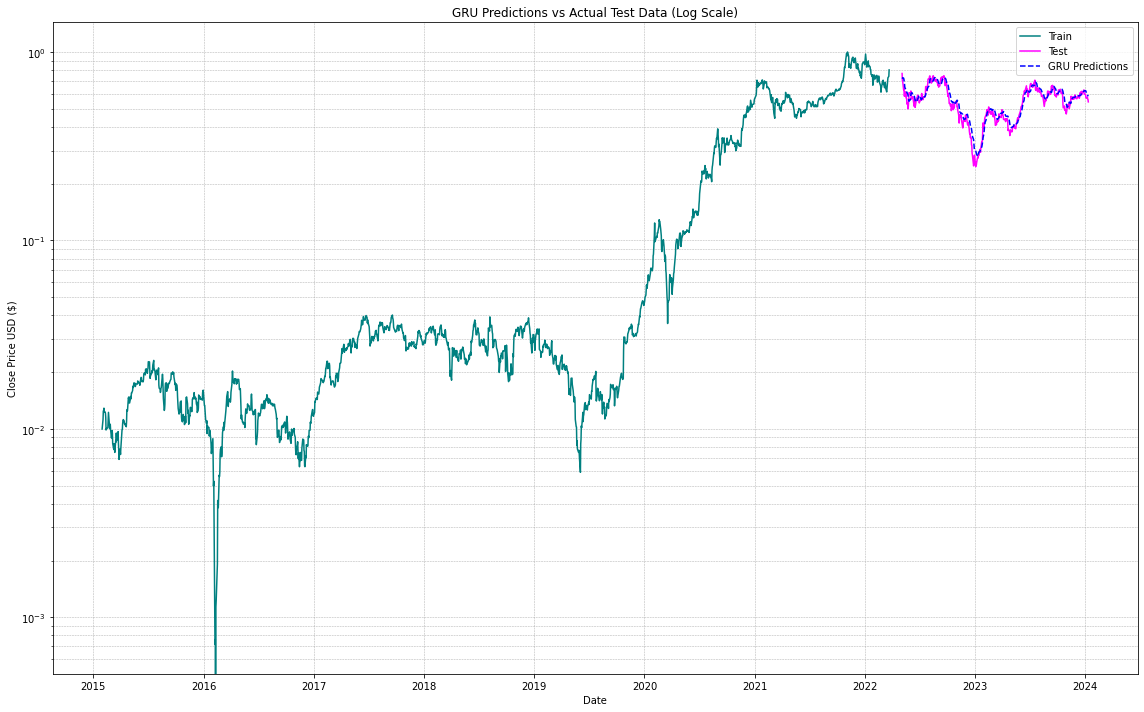

In [40]:
plot_test_train_prediction("GRU",df_train_scaled, df_test_scaled[5:], y_pred)
plot_test_train_prediction_log("GRU",df_train_scaled, df_test_scaled[5:], y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.03067599378307705
Root Mean Squared Error (RMSE) during High Volatility: 0.03630978017944704


/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:88: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rakibabdullah/Desktop/Tesla-S/Utils/Evaluation.py:94: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

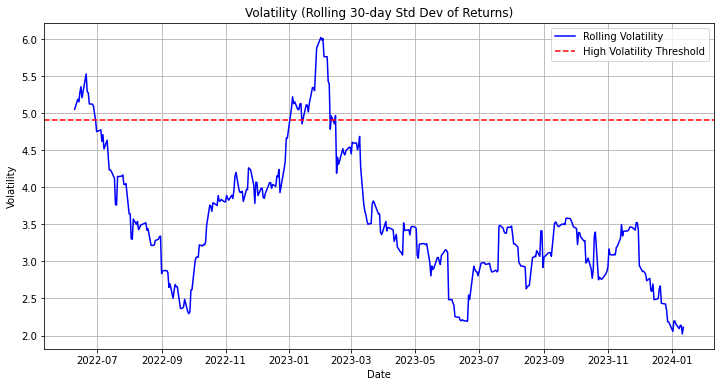

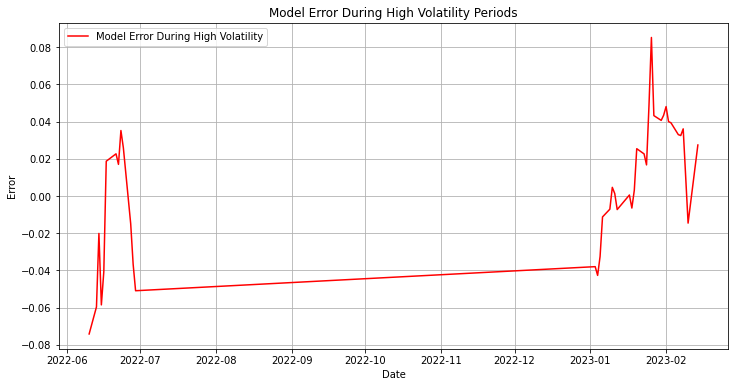

In [41]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test[5:], df_test_scaled[5:], y_pred)

volatility_period_metrics.append(("GRU", mae_volatility, rmse_volatility))

## Performance Comparison of Models at High Volatility Period

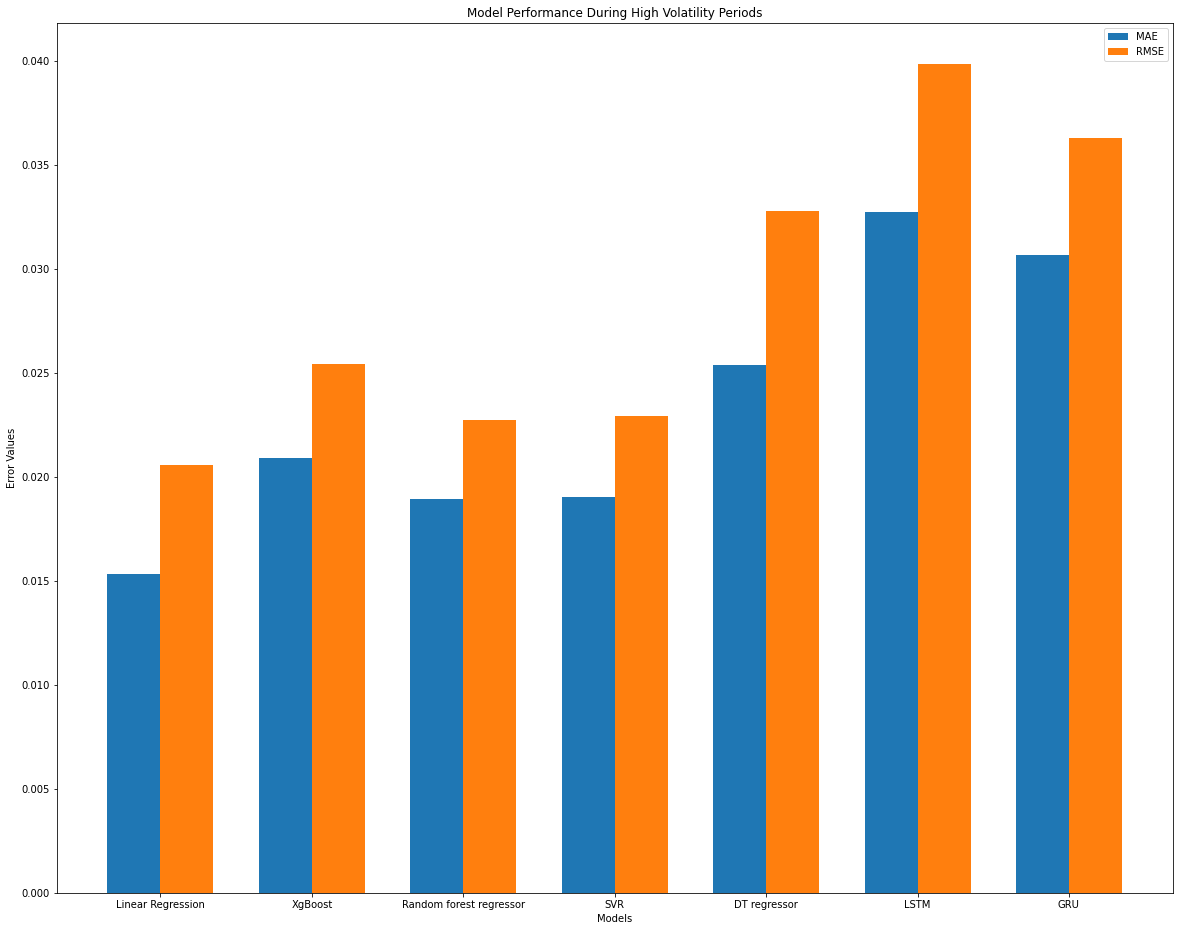

In [42]:
# Separate model names, MAE, and RMSE values
models = [model for model, _, _ in volatility_period_metrics]
mae_values = [mae for _, mae, _ in volatility_period_metrics]
rmse_values = [rmse for _, _, rmse in volatility_period_metrics]

# Plot comparison of MAE and RMSE for different models
x = np.arange(len(models))  # Model index

fig, ax = plt.subplots(figsize=(20, 16))
width = 0.35  # Bar width

# Plotting both MAE and RMSE side by side
bar1 = ax.bar(x - width/2, mae_values, width, label='MAE')
bar2 = ax.bar(x + width/2, rmse_values, width, label='RMSE')

ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('Model Performance During High Volatility Periods')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


## Walk Forward Validation Approach

In [43]:
feature_cols = ['Low', 'High', 'Open', 'Close', 'Volume', 'Monthly_Return', 'MA5', 'MA10', 'MA20']

# List of models with their names
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Support Vector Regressor", SVR(kernel='rbf', C=100, epsilon=0.1)),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("XGBoost", xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)),
    ("Voting Ensemble", VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('svr', SVR(kernel='rbf', C=100, epsilon=0.1)),
        ('dt', DecisionTreeRegressor(random_state=42)),
        ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)),
    ]))
]

results_walk_forward_training = []

for name,model_instance in models:
    print(f"Running Walk-Forward Validation for: {name}")
    y_true, y_pred = walk_forward_validation(df_test_scaled, 
                                         model_func=lambda m=model_instance: m, 
                                         feature_cols=feature_cols,
                                         start=100)
    # Evaluate model performance
    mae, mse, rmse, r2, mape=evaluate_model(y_true, y_pred)
    results_walk_forward_training.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    })


Running Walk-Forward Validation for: Linear Regression
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0150
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0198
R-squared (R²): 0.9652
Mean Absolute Percentage Error (MAPE): 3.1982%


Running Walk-Forward Validation for: Random Forest
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0319
Mean Squared Error (MSE): 0.0023
Root Mean Squared Error (RMSE): 0.0481
R-squared (R²): 0.7949
Mean Absolute Percentage Error (MAPE): 7.7740%


Running Walk-Forward Validation for: Support Vector Regressor
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0496
Mean Squared Error (MSE): 0.0059
Root Mean Squared Error (RMSE): 0.0769
R-squared (R²): 0.4763
Mean Absolute Percentage Error (MAPE): 12.3402%


Running Walk-Forward Validation for: Decision Tree
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0395
Mean Squared Error (MSE): 0.0030
Root Mean Squared Error (RMSE): 0.0552
R-squared (R²): 0.7305
Mean Absolute

## Performance of Models based on Different Evaluation Metices

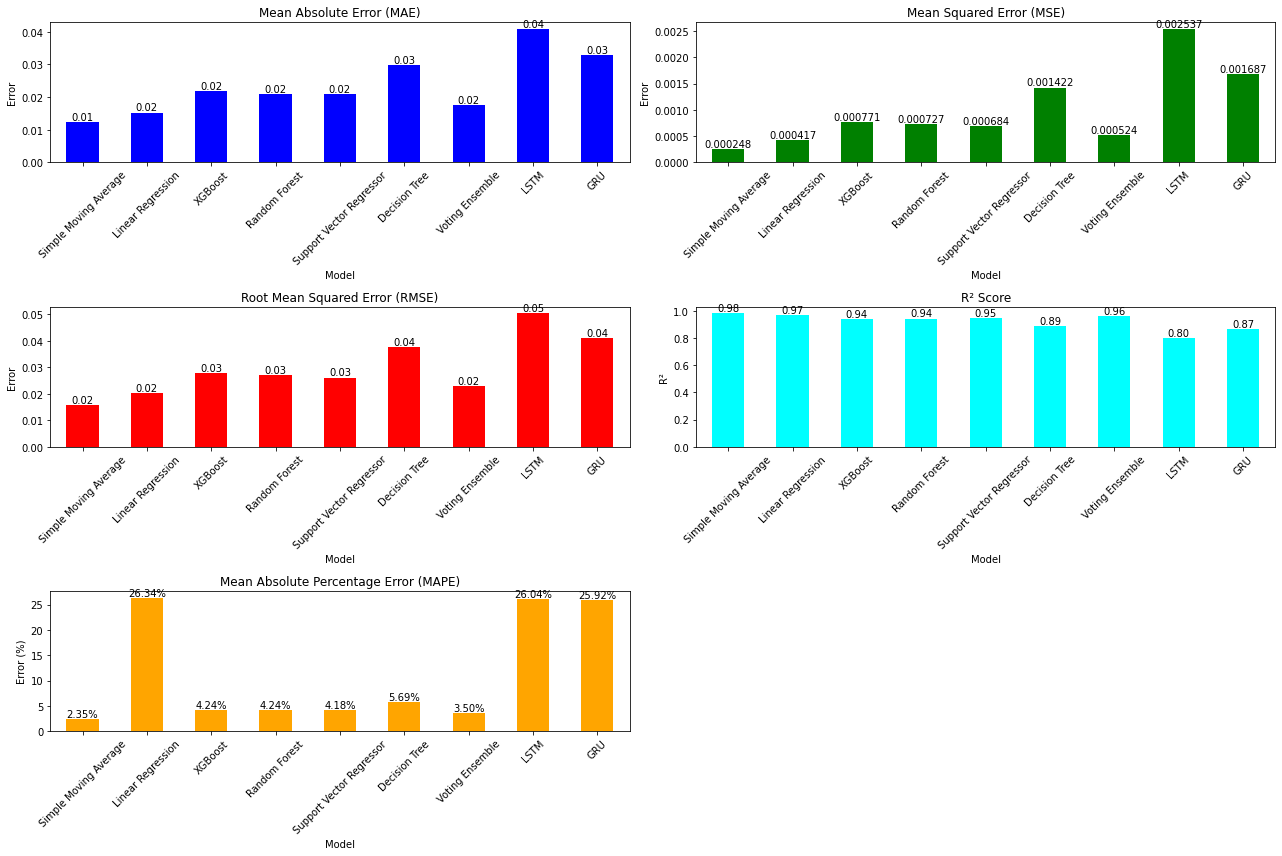

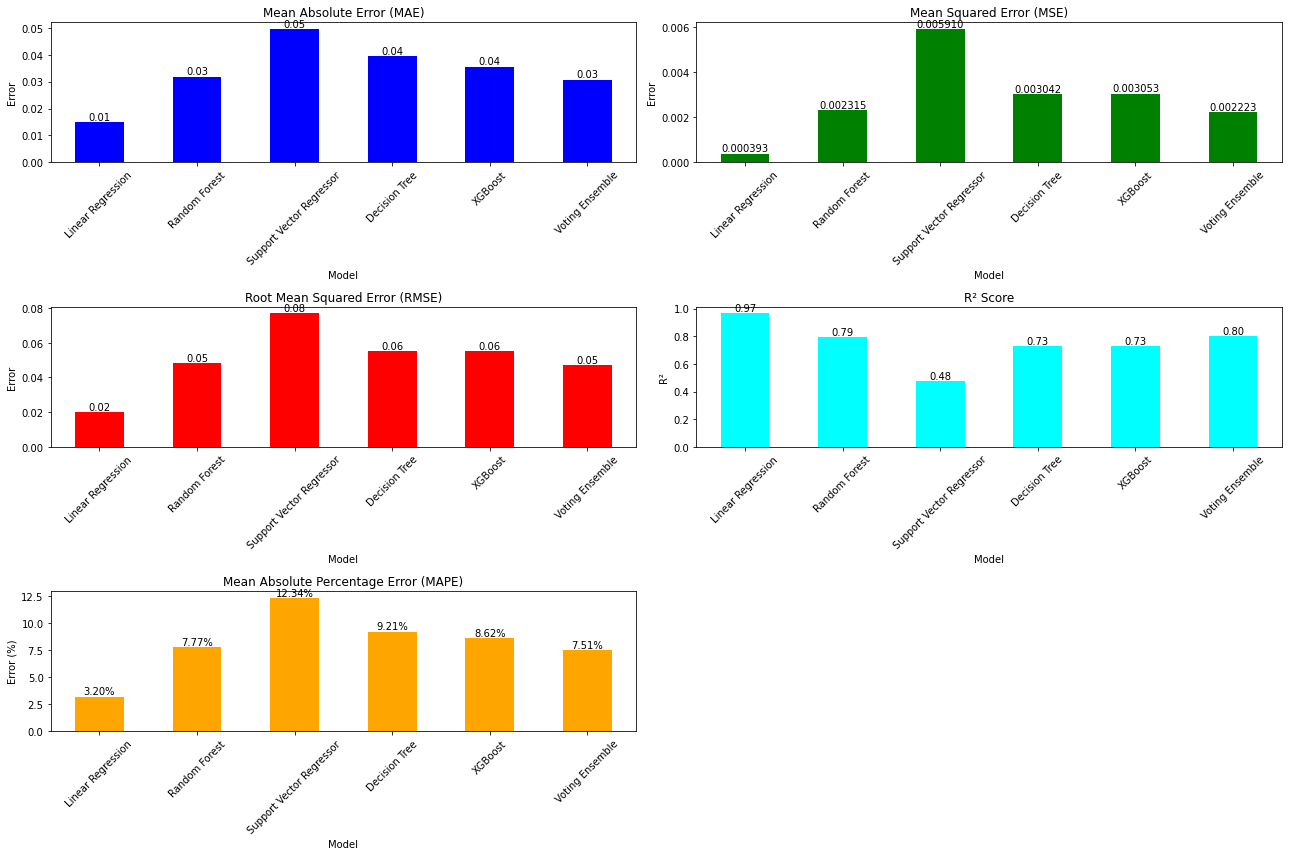

In [44]:
plot_model_comparsion(results_normal_training)
plot_model_comparsion(results_walk_forward_training)